In [8]:
from matplotlib import pyplot as plt
import pandas as pd

In [29]:
data = {
    "DilatedCNN(CH)": "../stats/seq_ch_conv_3lv.yaml-2020-05-15--13-36.30.csv",
    "DilatedCNN(CH+SY)": "../stats/seq_sy_ch_conv_3lv.yaml-2020-05-15--22-41.30.csv",
    "UniLSTM(CH)": "../stats/seq_ch_lstm_uni.yaml-2020-05-16--10-14.30.csv",
    "BiLSTM(CH)": "../stats/seq_ch_lstm_bi.yaml-2020-05-16--10-13.30.csv",
    "BiLSTM(CH+SY)": "../stats/seq_sy_ch_lstm_bi.yaml-2020-05-16--17-57.30.csv",
}

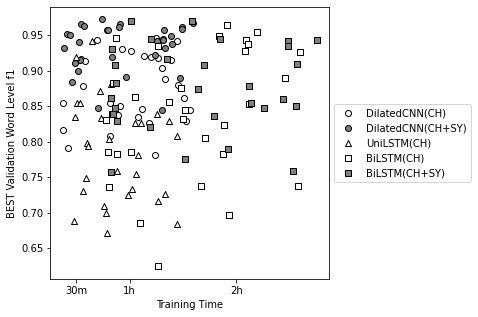

In [47]:
def maker(k):
    if "CNN" in k:
        return "o"
    elif "UniLSTM" in k:
        return "^"
    elif "BiLSTM" in k:
        return "s"
def plot_hyperopt(families, n=10):
    plt.figure(figsize=(5, 5))
    # draw max line
    for k in families:
        df = pd.read_csv(data[k]).sort_values(by="best-val:word_level:f1", ascending=False)[:n]
        plt.scatter(
            df["training_took"] / 60, df["best-val:word_level:f1"],
            label=k,
            marker=maker(k),
            edgecolor="black",
            facecolor="gray" if "SY" in k else "white"
        )

    plt.ylabel("BEST Validation Word Level f1")
    plt.xlabel("Training Time")
    plt.xticks([30, 60, 120], ["30m", "1h", "2h"])
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
plot_hyperopt(["DilatedCNN(CH)", "DilatedCNN(CH+SY)", "UniLSTM(CH)", "BiLSTM(CH)", "BiLSTM(CH+SY)"], n=30)